In [ ]:
# Copyright (c) 2024, NVIDIA CORPORATION.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append('../')

import re
import glob
import json
import random
import pickle
import numpy as np
from tqdm.auto import tqdm
from itertools import product

import cv2
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import torch

/home/weihua9217/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import BitsAndBytesConfig, LogitsProcessor
from peft import PeftModel

from llava.model.builder import load_pretrained_model
from llava.mm_utils import process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX

from efficientvit.sam_model_zoo import create_sam_model
from efficientvit.models.efficientvit.sam import EfficientViTSamPredictor

In [3]:
PRETRAINED = "lmms-lab/llama3-llava-next-8b"
ADAPTER_PATH = './checkpoint/sam4mllm/sam4mllm-checkpoint-3199'
EFFVIT_SAM_PATH = "./checkpoint/xl1.pt"

In [4]:
def load_model():
    tokenizer, model, image_processor, max_length = load_pretrained_model(
        PRETRAINED,
        None,
        "llava_llama3",
        device_map='cuda:0',
        # for v100
        torch_dtype=torch.float16,
        attn_implementation='eager',
        
        # for a100 or later 
        # torch_dtype=torch.bfloat16,
        # attn_implementation='flash_attention_2',
    )
    tokenizer.pad_token = tokenizer.eos_token
    model.generation_config.pad_token_id = tokenizer.pad_token_id

    model.eval()
    model.tie_weights()
    
    if ADAPTER_PATH:
        model = PeftModel.from_pretrained(model, ADAPTER_PATH)
    
    effvit_sam = create_sam_model(
        name="xl1", weight_url=EFFVIT_SAM_PATH,
    )
    effvit_sam = effvit_sam.cuda().eval()
    effvit_sam_predictor = EfficientViTSamPredictor(effvit_sam)
    
    return model, tokenizer, image_processor, effvit_sam_predictor

In [5]:
model, tokenizer, image_processor, effvit_sam_predictor = load_model()
model = model.eval()

Keyword arguments: {'torch_dtype': torch.float16, 'device_map': 'cuda:0'}


/home/weihua9217/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/home/weihua9217/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shar

In [6]:
grid_rand_points = [
    (93, 70), (51, 89), (91, 90), (32, 32), (88, 10),
    (12, 28), (29, 52), (49, 49), (28, 12), (59, 60),
    (9, 48), (52, 29), (31, 92), (68, 13), (73, 73),
    (69, 53), (48, 9), (19, 18), (71, 93), (53, 69),
    (89, 50), (11, 88), (33, 72), (39, 41), (72, 33),
    (13, 68), (79, 82), (8, 8), (81, 22), (92, 30),
]
grid_rand_points = np.array(grid_rand_points) / 100
grid_rand_points = grid_rand_points[:15]
number_tokens = tokenizer(' '.join([str(i) for i in range(1000)]), add_special_tokens=False)['input_ids'][::2]

In [7]:
grid_rand_points

array([[0.93, 0.7 ],
       [0.51, 0.89],
       [0.91, 0.9 ],
       [0.32, 0.32],
       [0.88, 0.1 ],
       [0.12, 0.28],
       [0.29, 0.52],
       [0.49, 0.49],
       [0.28, 0.12],
       [0.59, 0.6 ],
       [0.09, 0.48],
       [0.52, 0.29],
       [0.31, 0.92],
       [0.68, 0.13],
       [0.73, 0.73]])

In [8]:
test_img_path = './test_imgs/000000025515.jpg'
image = Image.open(test_img_path)

In [9]:
answer_counts = '1'
s_phrase = 'side view bird'
device = 'cuda:0'

In [10]:
image_tensor = process_images([image], image_processor, model.config)
image_tensor = [_image.to(dtype=torch.bfloat16) for _image in image_tensor]
image_sizes = [image.size]

In [11]:
prompt_question = tokenizer.apply_chat_template([
    {"role": "system", "content": "You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language."},
    {"role": "user", "content": f'<image>\nPlease provide the bounding box coordinate of the region this sentence describes ({answer_counts}):\n"{s_phrase}".'},
], tokenize=False, add_generation_prompt=True)
input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)

In [12]:
model = model.merge_and_unload()

In [13]:
with torch.backends.cuda.sdp_kernel(enable_flash=False):
    output = model.generate(
        input_ids,
        images=[x.half() for x in image_tensor],
        image_sizes=image_sizes,
        max_new_tokens=30,
    )

In [14]:
text_output = tokenizer.decode(output[0], skip_special_tokens=True)
text_output

'[281,251,863,999]'

In [15]:
def point_to_str(point):
    return f"({point[0]:03d},{point[1]:03d})"

In [16]:
bbox = [281,240,863,999]
bbox_txt = '[281,240,863,999]'
x1, y1, x2, y2 = bbox

rand_points = grid_rand_points * np.array([x2 - x1, y2 - y1]) + np.array([x1, y1])
rand_points = rand_points.astype(int)

points_txt = ' '.join([point_to_str(p) for p in rand_points])
question_points = f'Check if the points listed below are located on the object with coordinates {bbox_txt}:\n{points_txt}'

prompt_question = tokenizer.apply_chat_template([
    {"role": "system", "content": "You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language."},
    {"role": "user", "content": f'<image>\nPlease provide the bounding box coordinate of the region this sentence describes ({answer_counts}):\n"{s_phrase}".'},
    {"role": "assistant", "content": text_output},
    {"role": "user", "content": question_points},
], tokenize=False, add_generation_prompt=True)
input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)

In [17]:
output_2 = model.generate(
    input_ids,
    images=[x.half() for x in image_tensor],
    image_sizes=image_sizes,
    max_new_tokens=30,
    output_logits=True,
    return_dict_in_generate=True,
)

In [18]:
output_2[0]

tensor([[  2822,   2822,   2822,   9642,   2822,   9642,   9642,   9642,   9642,
           2822,   2822,   9642,   2822,   2822,   2822, 128009]],
       device='cuda:0')

In [19]:
text_output_2 = tokenizer.decode(output_2[0][0], skip_special_tokens=True)
text_output_2

'NoNoNoYesNoYesYesYesYesNoNoYesNoNoNo'

In [20]:
yesno_probs = torch.stack(output_2['logits'], dim=1).softmax(dim=-1)
yesno_probs = yesno_probs[0, :30, [2822, 9642]].float().cpu().numpy()

In [21]:
yesno_probs

array([[9.9998546e-01, 1.3845995e-05],
       [9.9847287e-01, 1.5247829e-03],
       [9.9999118e-01, 8.8011011e-06],
       [2.2341585e-04, 9.9977428e-01],
       [9.9999571e-01, 4.2228330e-06],
       [1.0987293e-03, 9.9889970e-01],
       [3.7052934e-05, 9.9996197e-01],
       [4.1485167e-01, 5.8503461e-01],
       [1.4413941e-01, 8.5579509e-01],
       [9.8981768e-01, 1.0169528e-02],
       [9.9398911e-01, 6.0035517e-03],
       [2.1156995e-03, 9.9788243e-01],
       [9.9839956e-01, 1.5978414e-03],
       [9.8754698e-01, 1.2431381e-02],
       [9.9961072e-01, 3.8596481e-04],
       [4.9652681e-07, 3.0590127e-07]], dtype=float32)

In [22]:
def sel_points(rand_points, all_probs_2, neg_thres=0.2, pos_thres=0.8):
    sel_points, sel_labels = [], []
    for (x, y), score in zip(rand_points, all_probs_2):
        if score[0] > neg_thres:
            sel_points.append((x, y)), sel_labels.append(0)
        elif score[1] > pos_thres:
            sel_points.append((x, y)), sel_labels.append(1)
    
    sel_points, sel_labels = np.array(sel_points), np.array(sel_labels)
    
    return sel_points, sel_labels

points_sel, labels_sel = sel_points(rand_points, yesno_probs, neg_thres=0.9, pos_thres=0.75)

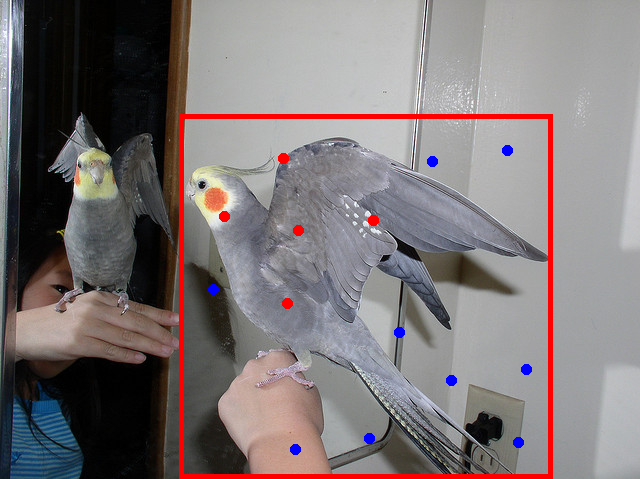

In [23]:
draw_image = image.copy()
draw = ImageDraw.Draw(draw_image)
img_w, img_h = image.size
draw.rectangle([x1/1000*img_w, y1/1000*img_h, x2/1000*img_w, y2/1000*img_h], outline='red', width=5)

for (x, y), label in zip(points_sel, labels_sel):
    draw.ellipse([x/1000*img_w-5, y/1000*img_h-5, x/1000*img_w+5, y/1000*img_h+5], fill='red' if label else 'blue')

draw_image

In [24]:
def sam_pred_mask(effvit_sam_predictor, points_sel, labels_sel, bbox, ori_img_w, ori_img_h):
    if len(points_sel) != 0:
        scaled_sel_points = points_sel / [1000, 1000] * [ori_img_w, ori_img_h]
    else:
        scaled_sel_points, labels_sel = None, None
    scaled_bbox = np.array(bbox) / 1000 * [ori_img_w, ori_img_h, ori_img_w, ori_img_h]
    pred_masks, scores, logits = effvit_sam_predictor.predict(
        point_coords=scaled_sel_points,
        point_labels=labels_sel,
        box=scaled_bbox[None, :],
        multimask_output=True,
    )
    pred_mask = pred_masks[scores.argmax()]
    
    return pred_mask

In [25]:
points_sel

array([[822, 771],
       [577, 915],
       [810, 923],
       [467, 482],
       [793, 315],
       [350, 452],
       [449, 634],
       [443, 331],
       [624, 695],
       [333, 604],
       [583, 460],
       [461, 938],
       [676, 338],
       [705, 794]])

In [26]:
labels_sel

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0])

In [27]:
bbox

[281, 240, 863, 999]

In [28]:
img_w

640

In [29]:
effvit_sam_predictor.set_image(np.array(image))
pred_mask = sam_pred_mask(
    effvit_sam_predictor, points_sel, labels_sel, bbox, img_w, img_h
)

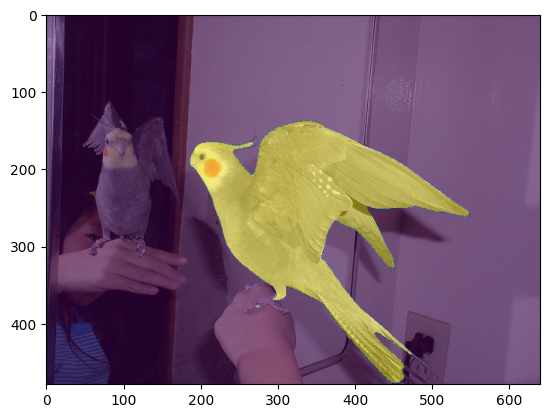

In [30]:
plt.imshow(image)
plt.imshow(pred_mask, alpha=0.5)
plt.show()